 # 使用LSTM进行情感分析

## 导入数据

首先，我们需要去创建词向量。为了简单起见，我们使用训练好的模型来创建。

作为该领域的一个最大玩家，Google 已经帮助我们在大规模数据集上训练出来了 Word2Vec 模型，包括 1000 亿个不同的词！在这个模型中，谷歌能创建 300 万个词向量，每个向量维度为 300。

在理想情况下，我们将使用这些向量来构建模型，但是因为这个单词向量矩阵相当大（3.6G），我们用另外一个现成的小一些的，该矩阵由 GloVe 进行训练得到。矩阵将包含 400000 个词向量，每个向量的维数为 50。

我们将导入两个不同的数据结构，一个是包含 400000 个单词的 Python 列表，一个是包含所有单词向量值得 400000*50 维的嵌入矩阵。


In [1]:
import numpy as np
#读取词数据集
wordsList = np.load('D:/training_data/wordsList.npy')
print('Loaded the word list!')#输出
#已经训练好的词向量模型
wordsList = wordsList.tolist() 
#给定相应格式
wordsList = [word.decode('UTF-8') for word in wordsList] 
#读取词向量数据集
wordVectors = np.load('D:/training_data/wordVectors.npy')
print ('Loaded the word vectors!')#输出

Loaded the word list!
Loaded the word vectors!


In [2]:
print(len(wordsList))#查看word list长度
print(wordVectors.shape)#查看woedvectors的词向量模型

400000
(400000, 50)


我们也可以在词库中搜索单词，比如 “baseball”，然后可以通过访问嵌入矩阵来得到相应的向量，如下：

In [3]:
badIndex = wordsList.index('bad')#在word list中搜索baseball
wordVectors[badIndex]#查看baseball这个词在词向量数据集中的参数

array([-0.17981 , -0.40407 , -0.1653  , -0.60687 , -0.39656 ,  0.12688 ,
       -0.053049,  0.38024 , -0.51008 ,  0.46593 , -0.30818 ,  0.79362 ,
       -0.85766 , -0.25143 ,  1.0448  ,  0.18628 ,  0.13688 ,  0.092588,
       -0.2236  , -0.13604 , -0.19482 ,  0.057702,  0.56133 ,  0.24823 ,
        0.627   , -1.8437  , -1.2573  ,  0.64482 ,  1.2787  , -0.29522 ,
        3.0493  ,  0.62079 ,  0.90369 , -0.030099, -0.13091 ,  0.30525 ,
       -0.070138, -0.12912 ,  0.72277 , -0.79774 , -0.70277 ,  0.038009,
        0.27192 ,  0.35679 ,  0.26493 ,  0.13037 , -0.01369 ,  0.33713 ,
        0.99956 ,  0.72031 ], dtype=float32)

现在我们有了向量，我们的第一步就是输入一个句子，然后构造它的向量表示。假设我们现在的输入句子是 “I thought the movie was incredible and inspiring”。为了得到词向量，我们可以使用 TensorFlow 的嵌入函数。这个函数有两个参数，一个是嵌入矩阵（在我们的情况下是词向量矩阵），另一个是每个词对应的索引。


In [4]:
#可以设置文章的最大词数来限制
maxSeqLength = 10 
#每个单词的最大维度
numDimensions = 300 
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#如果长度没达到设置的标准，用0来占位
print(firstSentence.shape)#查看类型
#结果
print(firstSentence) #查看结果

(10,)
[    41    804 201534   1005     15   7446      5  13767      0      0]


数据管道如下图所示：

输出数据是一个 10*50 的词矩阵，其中包括 10 个词，每个词的向量维度是 50。就是去找到这些词对应的向量

In [5]:
import tensorflow as tf#导入库
#用tensorflow查看数组类型
with tf.compat.v1.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)#查看数组的类型

(10, 50)


在整个训练集上面构造索引之前，我们先花一些时间来可视化我们所拥有的数据类型。这将帮助我们去决定如何设置最大序列长度的最佳值。在前面的例子中，我们设置了最大长度为 10，但这个值在很大程度上取决于你输入的数据。

训练集我们使用的是 IMDB 数据集。这个数据集包含 25000 条电影数据，其中 12500 条正向数据，12500 条负向数据。这些数据都是存储在一个文本文件中，首先我们需要做的就是去解析这个文件。正向数据包含在一个文件中，负向数据包含在另一个文件中。


In [6]:
from os import listdir
from os.path import isfile, join
#指定好数据集位置，由于提供的数据都一个个单独的文件，所以还得一个个读取
#将三个文件夹的内容放到一个文件下面
positiveFiles = ['D:/training_data/positiveReviews/' + f for f in listdir('D:/training_data/positiveReviews/') if isfile(join('D:/training_data/positiveReviews/', f))]
negativeFiles = ['D:/training_data/negativeReviews/' + f for f in listdir('D:/training_data/negativeReviews/') if isfile(join('D:/training_data/negativeReviews/', f))]
numWords = []#建一个空列表
#分别统计积极和消极情感数据集
#循环积极的数据集并添加到新类别里面
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('情感积极数据集加载完毕')
#同理
for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('情感消极数据集加载完毕')
#输出类表查看
numFiles = len(numWords)
print('总共文件数量', numFiles)
print('全部词语数量', sum(numWords))
print('平均每篇评论词语数量', sum(numWords)/len(numWords))

情感积极数据集加载完毕
情感消极数据集加载完毕
总共文件数量 25000
全部词语数量 5844680
平均每篇评论词语数量 233.7872


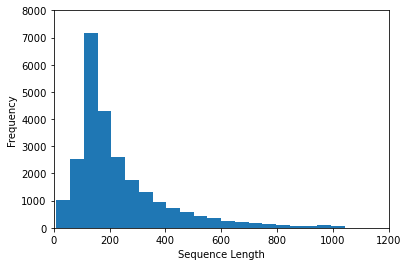

In [7]:
#绘图查看，主要查看句子的长度
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)#间隔50
plt.xlabel('Sequence Length')#x轴为长度
plt.ylabel('Frequency')#y轴为次数
plt.axis([0, 1200, 0, 8000])#设置图表的度量
plt.show()

从直方图和句子的平均单词数，我们认为将句子最大长度设置为 250 是可行的。

In [8]:
maxSeqLength = 250#设置筛选句子长度为250

接下来，让我们看看如何将单个文件中的文本转换成索引矩阵，比如下面的代码就是文本中的其中一个评论。

In [9]:
#随便哪一篇评论来看看结果
fname = positiveFiles[30] 
with open(fname) as f:
    for lines in f:
        print(lines)
        exit

Sure, Titanic was a good movie, the first time you see it, but you really should see it a second time and your opinion of the film will definetly change. The first time you see the movie you see the underlying love-story and think: ooh, how romantic. The second time (and I am not the only one to think this) it is just annoying and you just sit there watching the movie thinking, When is this d**n ship going to sink??? And even this is not as impressive when you see it several times. The acting in this film is not bad, but definetly not great either. Was I glad DiCaprio did not win an oscar for that film, I mean who does he think he is, Anthony Hopkins or Denzel Washington? He does 1 half-good movie and won't do a film for less than $20 million. And then everyone is suprised that there are hardly any films with him in it. But enough about, in my eyes, the worst character of the film. Kate Winslet's performance on the other hand was wonderful. I also tink that the director is very talente

接下来，我们将它转换成一个索引矩阵。

In [10]:
# 删除标点符号、括号、问号等，只留下字母数字字符
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")
#替换<br />为空值
def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [11]:
firstFile = np.zeros((maxSeqLength), dtype='int32')#输入矩阵并循环出25000评论的词在上面那一段句子的个数，长度设为250，少的用0替代，多的删除
#将每一个词放入矩阵中循环得出评分列表
with open(fname) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        try:
            firstFile[indexCounter] = wordsList.index(word)
        except ValueError:
            firstFile[indexCounter] = 399999 #Vector for unknown words
        indexCounter = indexCounter + 1
firstFile

array([  1085,  12608,     15,      7,    219,   1005, 201534,     58,
           79,     81,    253,     20,     34,     81,    588,    189,
          253,     20,      7,    126,     79,      5,    392,   2166,
            3, 201534,    319,     43, 399999,    511, 201534,     58,
           79,     81,    253, 201534,   1005,     81,    253, 201534,
         6814, 399999,      5,    269,  50199,    197,   5845, 201534,
          126,     79,      5,     41,    913,     36, 201534,     91,
           48,      4,    269,     37,     20,     14,    120,  17249,
            5,     81,    120,   3162,     63,   2641, 201534,   1005,
         2412,     61,     14,     37,  69502,   1370,    222,      4,
         9241,      5,    151,     37,     14,     36,     19,   4571,
           61,     81,    253,     20,    201,    246, 201534,   2050,
            6,     37,    319,     14,     36,    978,     34, 399999,
           36,    353,    900,     15,     41,   7392,  26114,    119,
      

现在，我们用相同的方法来处理全部的 25000 条评论。我们将导入电影训练集，并且得到一个 25000 * 250 的矩阵。这是一个计算成本非常高的过程，可以直接使用理好的索引矩阵文件。

In [12]:
#ids = np.zeros((numFiles, maxSeqLength), dtype='int32')#定义词组的类型
#fileCounter = 0
##积极的
#for pf in positiveFiles:
#    with open(pf, "r",encoding='utf-8') as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 
##消极的
#for nf in negativeFiles:
#    with open(nf, "r" ,encoding='utf-8') as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 
# #Pass into embedding function and see if it evaluates. 

In [13]:
#np.save('idsMatrix2.0', ids)#保存处理后的数据

In [14]:
ids = np.load('C:/Users/czl/大三小学期/第一周/idsMatrix2.0.npy')#导入数据

## 辅助函数

In [15]:
from random import randint
# 制作batch数据，通过数据集索引位置来设置训练集和测试集
#并且让batch中正负样本各占一半，同时给定其当前标签
def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

# RNN Model

现在，我们可以开始构建我们的 TensorFlow 图模型。首先，我们需要去定义一些超参数，比如批处理大小，LSTM的单元个数，分类类别和训练次数。

In [16]:
batchSize = 24#批处理大小
lstmUnits = 64#LSTM的单元个数
numClasses = 2#分类类别
iterations = 50000#训练次数

In [17]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()#将tensorflow2.0换成1.0

tf.reset_default_graph()#清除默认图形堆栈并重置全局默认图形

labels = tf.placeholder(tf.float32, [batchSize, numClasses])#函数参数，在执行的时候再赋具体的值
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

Instructions for updating:
non-resource variables are not supported in the long term


一旦，我们设置了我们的输入数据占位符，我们可以调用
tf.nn.embedding_lookup() 函数来得到我们的词向量。该函数最后将返回一个三维向量，第一个维度是批处理大小，第二个维度是句子长度，第三个维度是词向量长度。更清晰的表达，如下图所示：

In [18]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)#该操作返回一个带有形状shape的类型为dtype张量,并且所有元素都设为零.
data = tf.nn.embedding_lookup(wordVectors,input_data)#把每个词都映射成向量

现在我们已经得到了我们想要的数据形式，那么揭晓了我们看看如何才能将这种数据形式输入到我们的 LSTM 网络中。首先，我们使用 tf.nn.rnn_cell.BasicLSTMCell 函数，这个函数输入的参数是一个整数，表示需要几个 LSTM 单元。这是我们设置的一个超参数，我们需要对这个数值进行调试从而来找到最优的解。然后，我们会设置一个 dropout 参数，以此来避免一些过拟合。

最后，我们将 LSTM cell 和三维的数据输入到 tf.nn.dynamic_rnn ，这个函数的功能是展开整个网络，并且构建一整个 RNN 模型。



In [19]:
#lstmCell = tf.nn.rnn_cell.BasicLSTMCell(lstmUnits)
#lstmCell = tf.nn.rnn_cell.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)
#value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32) 
# 定义正向LSTM结构
lstm_fw_cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(lstmUnits, state_is_tuple=True),output_keep_prob=0.5)   
# 定义反向LSTM结构
lstm_bw_cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(lstmUnits, state_is_tuple=True),output_keep_prob=0.5)
# 将双向结构结合起来
value,_ = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell, lstm_bw_cell,data, dtype=tf.float32,)

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


<ipython-input-19-0c3ebf9db47d>:5: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_fw_cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(lstmUnits, state_is_tuple=True),output_keep_prob=0.5)
<ipython-input-19-0c3ebf9db47d>:7: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  lstm_bw_cell = tf.nn.rnn_cell.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(lstmUnits, state_is_tuple=True),output_keep_prob=0.5)


堆栈 LSTM 网络是一个比较好的网络架构。也就是前一个LSTM 隐藏层的输出是下一个LSTM的输入。堆栈LSTM可以帮助模型记住更多的上下文信息，但是带来的弊端是训练参数会增加很多，模型的训练时间会很长，过拟合的几率也会增加。

dynamic RNN 函数的第一个输出可以被认为是最后的隐藏状态向量。这个向量将被重新确定维度，然后乘以最后的权重矩阵和一个偏置项来获得最终的输出值。



In [20]:
##权重参数初始化
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value[0],[1,0,2])
##取最终的结果值
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

接下来，我们需要定义正确的预测函数和正确率评估参数。正确的预测形式是查看最后输出的0-1向量是否和标记的0-1向量相同。

In [21]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

之后，我们使用一个标准的交叉熵损失函数来作为损失值。对于优化器，我们选择 Adam，并且采用默认的学习率。

In [22]:
#用交叉熵损失函数来作为损失值
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
#选择Adam优化器，并且采用默认的学习率
optimizer = tf.train.AdamOptimizer().minimize(loss)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [23]:
#在tensorboard中绘图
tf.summary.scalar('acc',accuracy)
tf.summary.scalar('loss',loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

# 超参数调整

# 训练

训练过程的基本思路是，我们首先先定义一个 TensorFlow 会话。然后，我们加载一批评论和对应的标签。接下来，我们调用会话的 run 函数。这个函数有两个参数，第一个参数被称为 fetches 参数，这个参数定义了我们感兴趣的值。我们希望通过我们的优化器来最小化损失函数。第二个参数被称为 feed_dict 参数。这个数据结构就是我们提供给我们的占位符。我们需要将一个批处理的评论和标签输入模型，然后不断对这一组训练数据进行循环训练。



In [32]:
#训练
saver = tf.train.Saver()
#循环保存信息
with tf.Session() as sess:
    merge_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter("D:/data/logs/", sess.graph) #保存神经网络的所有的信息，方便浏览器访问
    sess.run(tf.global_variables_initializer())
    

    
    for i in range(iterations):
    #之前已经定义好的拿到batch数据函数
        nextBatch, nextBatchLabels = getTrainBatch();
        sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})
        
        
        
        #每隔1000次打印一下当前的结果
        if (i % 1000 == 0 and i != 0):
            loss_ = sess.run(loss, {input_data: nextBatch, labels: nextBatchLabels})
            accuracy_ = sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})

            result = sess.run(merge_summary, {input_data: nextBatch, labels: nextBatchLabels})
            writer.add_summary(result, i)

            print("iteration {}/{}...".format(i+1, iterations),
                  "loss {}...".format(loss_),
                  "accuracy {}...".format(accuracy_))    
      #每个1W次保存一下当前模型
        if (i % 10000 == 0 and i != 0):
            save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
            print("saved to %s" % save_path)

iteration 1001/50000... loss 0.48133882880210876... accuracy 0.75...
iteration 2001/50000... loss 0.5578255653381348... accuracy 0.6666666865348816...
iteration 3001/50000... loss 0.4463171064853668... accuracy 0.7916666865348816...
iteration 4001/50000... loss 0.560309886932373... accuracy 0.6666666865348816...
iteration 5001/50000... loss 0.6010549664497375... accuracy 0.625...
iteration 6001/50000... loss 0.5225700736045837... accuracy 0.7083333134651184...
iteration 7001/50000... loss 0.6023810505867004... accuracy 0.625...
iteration 8001/50000... loss 0.6372889876365662... accuracy 0.5833333134651184...
iteration 9001/50000... loss 0.3969896733760834... accuracy 0.8333333134651184...
iteration 10001/50000... loss 0.5565477013587952... accuracy 0.6666666865348816...
INFO:tensorflow:models\pretrained_lstm.ckpt-10000.data-00000-of-00001
INFO:tensorflow:7700
INFO:tensorflow:models\pretrained_lstm.ckpt-10000.index
INFO:tensorflow:7700
INFO:tensorflow:models\pretrained_lstm.ckpt-10000.m

![caption](Images/SentimentAnalysis6.png)
![caption](Images/SentimentAnalysis7.png)

查看上面的训练曲线，我们发现这个模型的训练结果还是不错的。损失值在稳定的下降，正确率也不断的在接近 100% 。然而，当分析训练曲线的时候，我们应该注意到我们的模型可能在训练集上面已经过拟合了。过拟合是机器学习中一个非常常见的问题，表示模型在训练集上面拟合的太好了，但是在测试集上面的泛化能力就会差很多。也就是说，如果你在训练集上面取得了损失值是 0 的模型，但是这个结果也不一定是最好的结果。当我们训练 LSTM 的时候，提前终止是一种常见的防止过拟合的方法。基本思路是，我们在训练集上面进行模型训练，同事不断的在测试集上面测量它的性能。一旦测试误差停止下降了，或者误差开始增大了，那么我们就需要停止训练了。因为这个迹象表明，我们网络的性能开始退化了。

导入一个预训练的模型需要使用 TensorFlow 的另一个会话函数，称为 Server ，然后利用这个会话函数来调用 restore 函数。这个函数包括两个参数，一个表示当前的会话，另一个表示保存的模型。


In [33]:
sess = tf.InteractiveSession()#使用这个会话可以得到张量的结果
saver = tf.train.Saver()#保存加载模型
saver.restore(sess, tf.train.latest_checkpoint('models'))#checkpoints文件保存和从checkpoints文件中恢复变量

INFO:tensorflow:Restoring parameters from models\pretrained_lstm.ckpt-40000


然后，从我们的测试集中导入一些电影评论。请注意，这些评论是模型从来没有看见过的。

In [34]:
iterations = 10#导入10条
#循环查看精确率
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 50.0
Accuracy for this batch: 66.66666865348816
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 33.33333432674408
Accuracy for this batch: 66.66666865348816
Accuracy for this batch: 66.66666865348816
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 75.0
Accuracy for this batch: 58.33333134651184
